In [9]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8



warnings.filterwarnings('ignore')

## Data loading 

In [10]:
df = pd.read_csv ('rhc.csv')
df.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [11]:
df.columns

Index(['Unnamed: 0', 'cat1', 'cat2', 'ca', 'sadmdte', 'dschdte', 'dthdte',
       'lstctdte', 'death', 'cardiohx', 'chfhx', 'dementhx', 'psychhx',
       'chrpulhx', 'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx',
       'transhx', 'amihx', 'age', 'sex', 'edu', 'surv2md1', 'das2d3pc',
       't3d30', 'dth30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1',
       'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1',
       'paco21', 'ph1', 'swang1', 'wtkilo1', 'dnr1', 'ninsclas', 'resp',
       'card', 'neuro', 'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma',
       'ortho', 'adld3p', 'urin1', 'race', 'income', 'ptid'],
      dtype='object')

In [310]:
df['ca'].value_counts()

No            4379
Yes            972
Metastatic     384
Name: ca, dtype: int64

## Data Cleaning

In [34]:
features=['swang1','death','age','sex','race','edu','income',
          'ninsclas','cat1','das2d3pc','dnr1','ca',
          'surv2md1','aps1','scoma1','wtkilo1','temp1',
          'meanbp1','resp1','hrt1','pafi1','paco21','wblc1',
          'hema1','sod1','pot1','crea1','bili1','alb1','resp',
          'card','neuro','gastr','renal','meta','hema','seps',
          'trauma','ortho','cardiohx','chfhx','dementhx','psychhx',
          'chrpulhx','renalhx','liverhx','gibledhx','malighx','immunhx','transhx','amihx']

In [312]:
obj_col=['death','dnr1','resp','card','neuro','gastr','renal','meta','hema','seps','trauma','ortho']

def CleanData(df,features=features,obj_col=obj_col):
    obj=df[features].copy()
    
    # mapping bicategorial columns
    mapping = {'No': 0, 'Yes': 1}
    for col in obj_col:
        obj[col]=obj[col].map(mapping)
    mapping = {'Female': 0, 'Male': 1}
    obj['sex']=obj['sex'].map(mapping)
    mapping = {'No RHC': 0, 'RHC': 1}
    obj['swang1']=obj['swang1'].map(mapping)
    
    #mapping multicategorial columns
    ohe = OneHotEncoder()
    ohe_results=ohe.fit_transform(obj[['race']])
    obj=obj.join(pd.DataFrame(ohe_results.toarray(), columns=ohe.categories_,dtype=int))
    obj.drop(['race'],axis=1,inplace=True)

    ohe = OneHotEncoder()
    ohe_results=ohe.fit_transform(obj[['ninsclas']])
    obj=obj.join(pd.DataFrame(ohe_results.toarray(), columns=ohe.categories_,dtype=int))
    obj.drop(['ninsclas'],axis=1,inplace=True)
    
    ohe = OneHotEncoder()
    ohe_results=ohe.fit_transform(obj[['ca']])
    obj=obj.join(pd.DataFrame(ohe_results.toarray(), columns=ohe.categories_,dtype=int))
    obj.drop(['ca'],axis=1,inplace=True)

    ohe = OneHotEncoder()
    ohe_results=ohe.fit_transform(obj[['cat1']])
    obj=obj.join(pd.DataFrame(ohe_results.toarray(), columns=ohe.categories_,dtype=int))
    obj.drop(['cat1'],axis=1,inplace=True)
    
    #mapping ordinal columns
    categories = pd.Categorical(obj['income'], categories=['Under $11k', '$11-$25k', '$25-$50k','> $50k'], ordered=True)
    labels, unique = pd.factorize(categories, sort=True)
    obj['income'] = labels
    
    #change columns names
    columns=[]
    for col in obj.columns:
        if type(col)==tuple:
            columns.append(col[0])
        else:
            columns.append(col)
    obj.columns=columns 
    return obj

In [313]:
RhcData=CleanData(df,features,obj_col=obj_col)
RhcData.head()

,swang1,death,age,sex,edu,income,das2d3pc,dnr1,surv2md1,aps1,...,Yes,ARF,CHF,COPD,Cirrhosis,Colon Cancer,Coma,Lung Cancer,MOSF w/Malignancy,MOSF w/Sepsis
0,0,0,70.25098,1,12.000000,0,23.50000,0,0.640991,46,...,1,0,0,1,0,0,0,0,0,0
1,1,1,78.17896,0,12.000000,0,14.75195,0,0.755000,50,...,0,0,0,0,0,0,0,0,0,1
2,1,0,46.09198,0,14.069916,2,18.13672,0,0.317000,82,...,1,0,0,0,0,0,0,0,1,0
3,0,1,75.33197,0,9.000000,1,22.92969,0,0.440979,48,...,0,1,0,0,0,0,0,0,0,0
4,1,1,67.90997,1,9.945259,0,21.05078,1,0.437000,72,...,0,0,0,0,0,0,0,0,0,1


## High level Analysis

In [314]:
RhcData.describe()

,swang1,death,age,sex,edu,income,das2d3pc,dnr1,surv2md1,aps1,...,Yes,ARF,CHF,COPD,Cirrhosis,Colon Cancer,Coma,Lung Cancer,MOSF w/Malignancy,MOSF w/Sepsis
count,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,...,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000
mean,0.380820,0.648997,61.375883,0.556582,11.678461,0.750480,20.496888,0.114037,0.592450,54.667655,...,0.169486,0.434176,0.079512,0.079686,0.039058,0.001221,0.076024,0.006800,0.069573,0.213949
std,0.485631,0.477325,16.681929,0.496831,3.145831,0.985236,5.317186,0.317883,0.195354,19.956434,...,0.375213,0.495691,0.270559,0.270830,0.193751,0.034918,0.265060,0.082191,0.254448,0.410127
min,0.000000,0.000000,18.041990,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,50.149490,0.000000,10.000000,0.000000,16.058590,0.000000,0.470947,41.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,64.047000,1.000000,12.000000,0.000000,19.746090,0.000000,0.628000,54.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,73.932465,1.000000,13.000000,1.000000,23.429690,0.000000,0.743000,67.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,101.847960,1.000000,30.000000,3.000000,33.000000,1.000000,0.962000,147.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


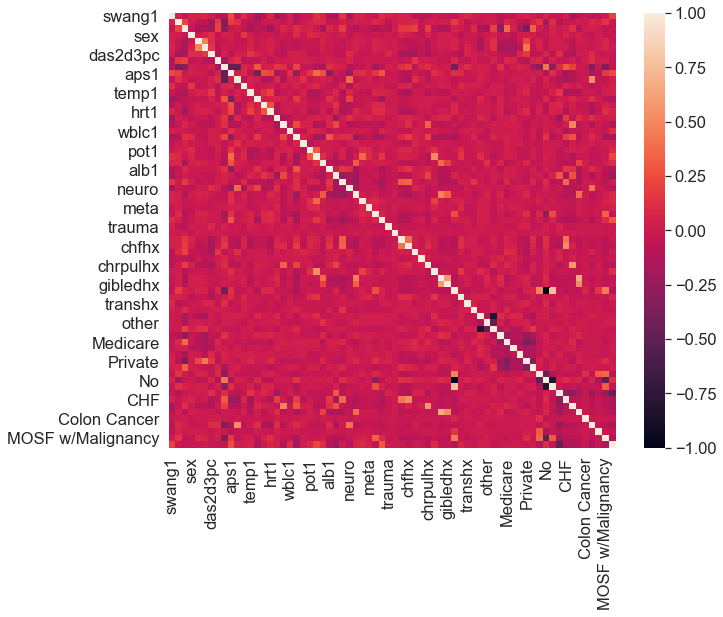

In [315]:
sns.heatmap(RhcData.corr(), vmin=-1, vmax=1);

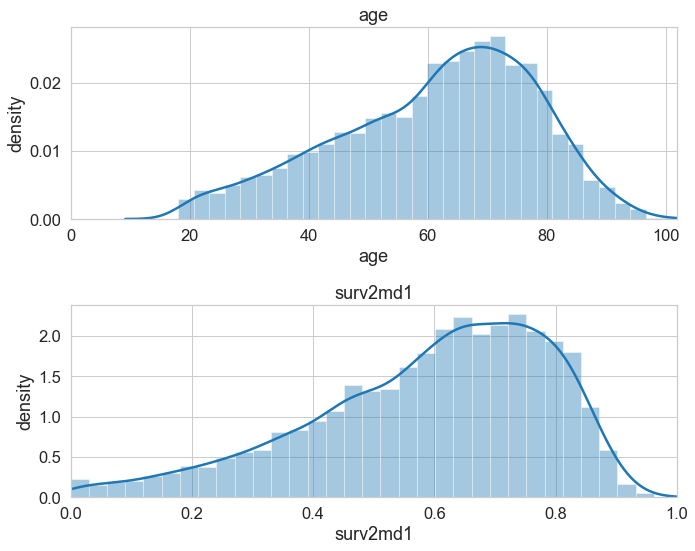

In [50]:
f, (ax1, ax2) = plt.subplots(2)
ax1.set_title('age')
ax1.set_xlabel('years')
ax1.set_ylabel('density')
ax1.set_xlim(0, np.max(RhcData['age']))
ax2.set_title('surv2md1')
ax2.set_xlabel('0 = lowest severity, 1 = highest severity')
ax2.set_ylabel('density')
ax2.set_xlim(0, 1)
sns.distplot(RhcData['age'], ax=ax1)
sns.distplot(RhcData['surv2md1'], ax=ax2)
plt.tight_layout();

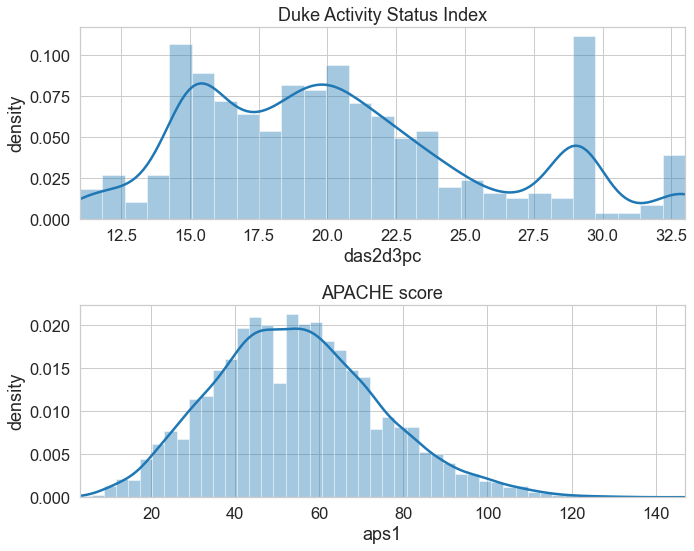

In [51]:
f, (ax1, ax2) = plt.subplots(2)
ax1.set_title('Duke Activity Status Index')
ax1.set_xlabel('')
ax1.set_ylabel('density')
ax1.set_xlim(np.min(RhcData['das2d3pc']), np.max(RhcData['das2d3pc']))
ax2.set_title('APACHE score')
label='0: low severity 100:high severity'
ax2.set_xlabel(label)
ax2.set_ylabel('density')
ax2.set_xlim(np.min(RhcData['aps1']), np.max(RhcData['aps1']))
sns.distplot(RhcData['das2d3pc'], ax=ax1)
sns.distplot(RhcData['aps1'], ax=ax2)
plt.tight_layout();

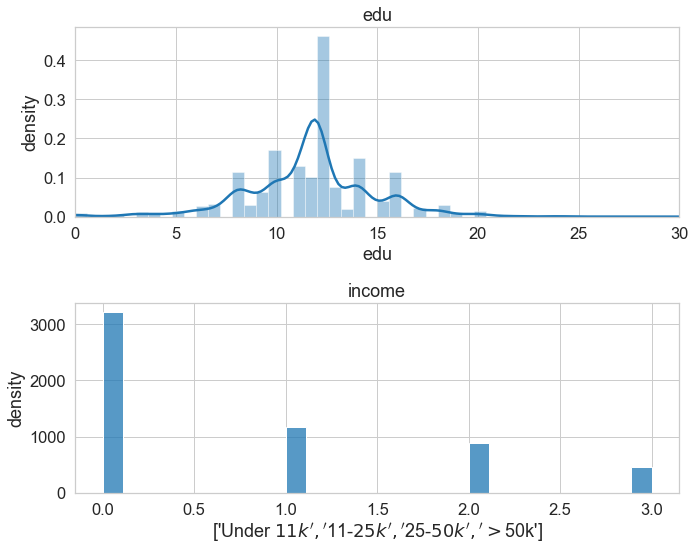

In [52]:
f, (ax1, ax2) = plt.subplots(2)
ax1.set_title('edu')
ax1.set_xlabel('years')
ax1.set_ylabel('density')
ax1.set_xlim(0, np.max(RhcData['edu']))
ax2.set_title('income')
categories=['Under $11k', '$11-$25k', '$25-$50k','> $50k']
ax2.set_xlabel(categories)
ax2.set_ylabel('density')
#ax2.set_xlim(0, 1)
sns.distplot(RhcData['edu'], ax=ax1)
sns.histplot(RhcData['income'], ax=ax2)
plt.tight_layout();

In [61]:
#passage en array
T=RhcData['swang1'].values
Y=RhcData['death'].values
X=RhcData.drop(['swang1','death'],axis=1,inplace=False).values

In [64]:
#calculate balance of dataset
df['swang1'].value_counts()

No RHC    3551
RHC       2184
Name: swang1, dtype: int64

## SMD Analysis

In [316]:
#passage en array
Tdf=RhcData['swang1']
Tdf.name='T'
Ydf=RhcData['death']
Ydf.name='Y'
Xdf=RhcData.drop(['swang1','death'],axis=1,inplace=False)

In [317]:
def create_table_one_df(dataframe=Xdf,T=Tdf,round_digits=4):
    mean_pos=Xdf[T==1].mean(axis=0)
    table_one=pd.DataFrame({'Mean Treatment':mean_pos})

    std_pos=Xdf[T==1].std(axis=0)
    table_one=table_one.join(pd.DataFrame({'Std Treatment':std_pos}),on=None)

    mean_neg=Xdf[T==0].mean(axis=0)
    table_one=table_one.join(pd.DataFrame({'Mean Control':mean_neg}),on=None)

    std_neg=Xdf[T==0].std(axis=0)
    table_one=table_one.join(pd.DataFrame({'Std Control':std_neg}),on=None)

    SMD=np.round(abs((mean_pos - mean_neg) / np.sqrt((std_pos ** 2 + std_neg ** 2) / 2)),round_digits)
    table_one=table_one.join(pd.DataFrame({'SMD':SMD}),on=None)
    return table_one

In [318]:
table_one=create_table_one_df(dataframe=Xdf,T=Tdf,round_digits=4)
table_one.loc[table_one['SMD']>=0.1]

,Mean Treatment,Std Treatment,Mean Control,Std Control,SMD
income,0.833333,1.015982,0.699521,0.962448,0.1352
dnr1,0.070971,0.256835,0.140524,0.347579,0.2276
surv2md1,0.568458,0.198316,0.607206,0.192054,0.1985
aps1,60.739011,20.271285,50.933540,18.813767,0.5014
scoma1,18.973443,28.264655,22.253168,31.373584,0.1098
wtkilo1,72.360180,27.729558,65.040241,29.501741,0.2557
meanbp1,68.197802,34.242209,84.868629,38.874134,0.4551
resp1,26.651557,14.174843,28.978118,13.946447,0.1655
hrt1,118.928114,41.470727,112.872994,40.941097,0.1469
pafi1,192.433403,105.537749,240.626632,116.661005,0.4332


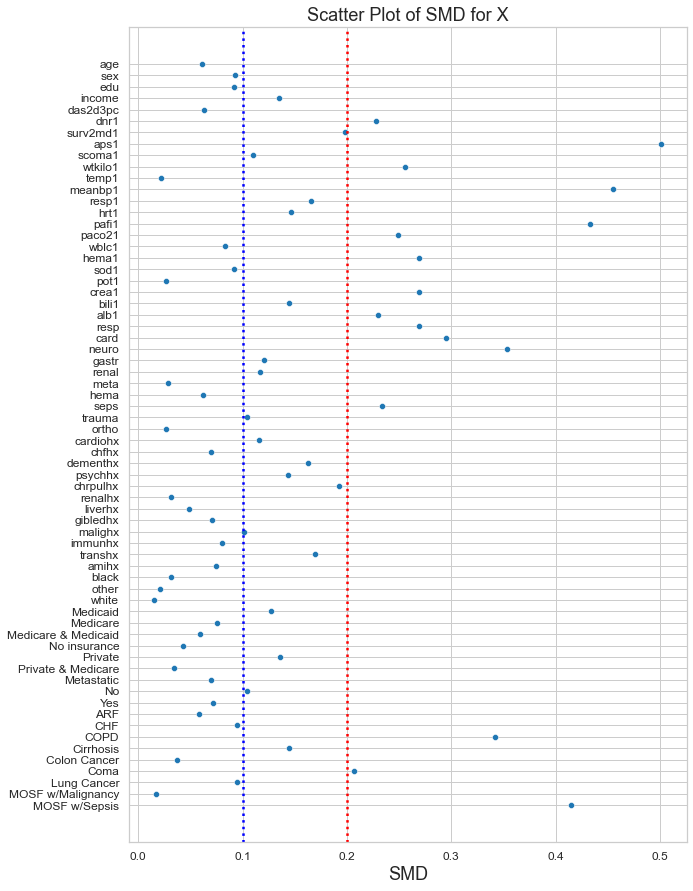

In [319]:
fig = plt.figure(figsize=(10, 15))
sns.scatterplot(table_one['SMD'],table_one.index)
plt.axvline(0.1, 0,1,ls=':',c='b')
plt.axvline(0.2, 0,1,ls=':',c='r')
plt.title("Scatter Plot of SMD for X", fontsize = 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Calculate propensty score

In [364]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [396]:
# classifier to estimate the propensity score
cls = LogisticRegression()
#cls = GaussianNB()  # another possible propensity score estimator

pipe=Pipeline([('scaler', StandardScaler()), ('cls', LogisticRegression())])

lr=GridSearchCV(
    estimator=pipe,
    param_grid={"cls__penalty": ('l1', 'l2', 'elasticnet'), "cls__solver": ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')},
    cv=5,
    n_jobs=-1,
)

X = Xdf.to_numpy()
t = Tdf.values
lr.fit(X, t)

# calibration of the classifier
print(lr.best_params_)
cls = CalibratedClassifierCV(lr.best_estimator_)
cls.fit(X, t)
cls.score(X, t)

{'cls__penalty': 'l1', 'cls__solver': 'liblinear'}


0.7340889276373147

In [391]:
propensity = pd.DataFrame(cls.predict_proba(X))
propensity.head()

,0,1
0,0.668677,0.331323
1,0.400725,0.599275
2,0.422067,0.577933
3,0.600638,0.399362
4,0.622655,0.377345


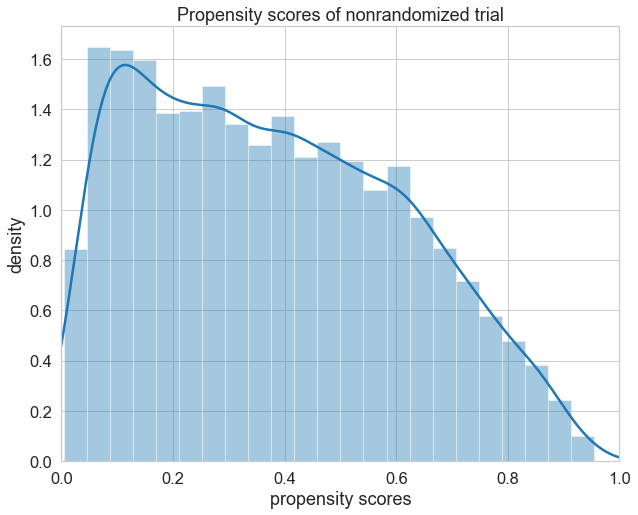

In [392]:
ax = sns.distplot(propensity[1].values)
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of nonrandomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

In [ ]:
# classifier to estimate the propensity score

pipe=Pipeline([('scaler', StandardScaler()), ('cls', GaussianNB())])


X = Xdf.to_numpy()
t = Tdf.values
lr.fit(X, t)

# calibration of the classifier
print(lr.best_params_)
cls = CalibratedClassifierCV(lr.best_estimator_)
cls.fit(X, t)
cls.score(X, t)